In [1]:
import sys
sys.path.insert(0, '../../utils/')
from utils import *
from pylab import *
from utils_date import *
import pickle
from tqdm import tqdm
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

import itertools

In [2]:
def create_xy_dataset(df_Xy, time_series, features_exogenous, features_context):
    df_Xy = copy.deepcopy(df_Xy[time_series+features_exogenous+features_context].dropna())
    days = sorted(list(set([i[:10] for i in df_Xy.index.values])))
    Xnames = [f+'-T'+str(ix)for f in features_exogenous for ix in np.arange(96)] + features_context
    
    X = []
    list_y=[]
    for d in tqdm(days,desc='Days loop'):
        ex = df_Xy.loc[d+' 00:00:00': d+ ' 23:45:00'][features_exogenous].values.T.flatten()
        co = df_Xy.loc[[d+' 00:00:00']][features_context].values.flatten()
        X.append(np.concatenate([ex, co]))
        y = []
        for s in time_series:
            y.append(df_Xy.loc[d+' 00:00:00': d+ ' 23:45:00'][s].values)
        list_y.append(y)
        
    return np.array(X), np.swapaxes(np.array(list_y),0,1), Xnames, days


In [4]:
# Data

observation_data_path = ['/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv']
exogenous_data_path = ['/home/toque/data2/montreal/events/data/clean/events_2015_2018_end_event_stopid.csv',
                       '/home/toque/data2/montreal/events/data/clean/events_2015_2018_start_event_stopid.csv',
                       '/home/toque/data2/montreal/events/data/clean/events_2015_2018_period_event_stopid.csv',
                       '/home/toque/data2/weather/predicted_weather/predicted_weather_2015_2017_included_perday_pm.csv'
                      ]
context_data_path = ['/home/toque/data2/date/2013-01-01-2019-01-01_new.csv']

df_observation = read_csv_list(observation_data_path)
df_exogenous = read_csv_list(exogenous_data_path)
df_context = read_csv_list(context_data_path)

# fill timestamps not available with 0 to have 96 timestamps per day
days = sorted(list(set([i[:10] for i in df_observation['Datetime'].values])))
timestamp_list = [j for i in [build_timestamp_list(d+' 00:00:00', d+' 23:45:00', time_step_second=15*60) for d in days] for j in i]
df_date = pd.DataFrame(data = timestamp_list, columns = ['Datetime']).set_index('Datetime')
df_observation = df_date.join(df_observation.set_index('Datetime')).fillna(0).reset_index()

In [8]:
time_series = ['11', '32', '34', '15', '44', '65', '31', '33', '35', '47', '13',
       '14', '1', '9', '5', '18', '36', '24', '68', '43', '8', '64', '10',
       '55', '3', '49', '51', '2', '19', '56', '7', '6', '4', '48', '66',
       '25', '23', '28', '39', '54', '60', '27', '20', '46', '12', '21',
       '62', '52', '41', '50', '30', '16', '37', '40', '26', '67', '57',
       '61', '42', '45', '38', '29', '58', '63', '22', '59', '53', '17']

features_exogenous = ['5-end_event', '11-end_event', '12-end_event', '13-end_event',
       '15-end_event', '16-end_event', '23-end_event', '24-end_event',
       '31-end_event', '32-end_event', '35-end_event', '43-end_event',
       '45-end_event', '61-end_event', '68-end_event', '5-start_event',
       '11-start_event', '12-start_event', '13-start_event',
       '15-start_event', '16-start_event', '23-start_event',
       '24-start_event', '31-start_event', '32-start_event',
       '35-start_event', '43-start_event', '45-start_event',
       '61-start_event', '68-start_event', '5-period_event',
       '11-period_event', '12-period_event', '13-period_event',
       '15-period_event', '16-period_event', '23-period_event',
       '24-period_event', '31-period_event', '32-period_event',
       '35-period_event', '43-period_event', '45-period_event',
       '61-period_event', '68-period_event']



features_context = ['Day_id', 'Mois_id','vac_noel_quebec', 'day_off_quebec', '24DEC', '31DEC',
                    'renov_beaubien', 'vac_udem1', 'vac_udem2']

scaler_choice_X = None
scaler_choice_y = None

param_kfold={
    'n_splits': 5,
    'shuffle': True,
    'random_state': 1}

param_grid={
    'n_estimators': [100, 150, 200],
    'max_features': ['auto',None],
    'max_depth': [None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,5,10],
    'n_jobs': [6],
    'criterion': ['mse']}



start_datetime, end_datetime = '2015-01-01 00:00:00', '2016-12-31 23:45:00'
model_name = 'mt_rf_uni_inverted_events_OPTIMALL'

In [5]:
df_Xy = df_observation.set_index('Datetime').join([df_context.set_index('Datetime'), df_exogenous.set_index('Datetime')])

df_Xy_train = df_Xy[start_datetime:end_datetime]
Xtrain, ytrain_list, Xnames, days = create_xy_dataset(df_Xy_train, time_series, features_exogenous, features_context)

Days loop: 100%|██████████| 731/731 [00:06<00:00, 115.68it/s]


In [11]:
grid_search_dict_pertimeseries = load_pickle('/home/toque/data2/forecast/model/rf_uni_inverted/optimize/'+model_name+'/grid_search_dict_pertimeseries.pkl')
best_arg = dict([(ts, grid_search_dict_pertimeseries[ts]['val']['rmse']['mean'].argmin()) for ts in time_series])
keys, values = zip(*param_grid.items())
all_params = [dict(zip(keys, v)) for v in itertools.product(*values)]
best_params_pertimeseries = dict([(ts, all_params[best_arg[ts]]) for ts in time_series])


In [13]:
df_Xy = df_observation.set_index('Datetime').join([df_context.set_index('Datetime'), df_exogenous.set_index('Datetime')])
df_Xy_train = df_Xy[start_datetime:end_datetime]
Xtrain, ytrain_list, Xnames, days = create_xy_dataset(df_Xy_train, time_series, features_exogenous, features_context)

rf_list = []
for ts, ytrain in tqdm(zip(time_series, ytrain_list)):
    best_params = best_params_pertimeseries[ts]
    rf = RandomForestRegressor(**best_params, verbose=0)
    rf.fit(Xtrain,ytrain)
    rf_list.append(rf)

Days loop: 100%|██████████| 731/731 [00:06<00:00, 116.41it/s]
68it [01:56,  2.01s/it]


# Features importances

MODEL Stop id:11, stop name:Station Berri-UQAM


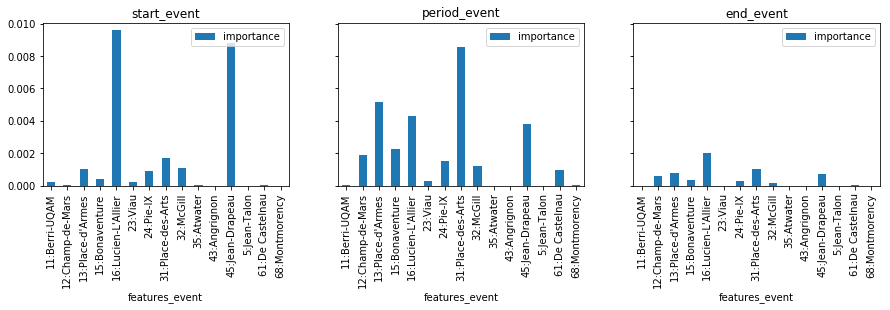

MODEL Stop id:32, stop name:Station McGill


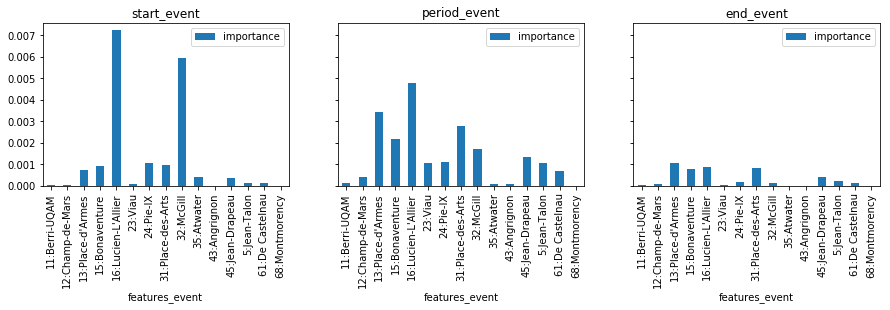

MODEL Stop id:34, stop name:Station Guy-Concordia


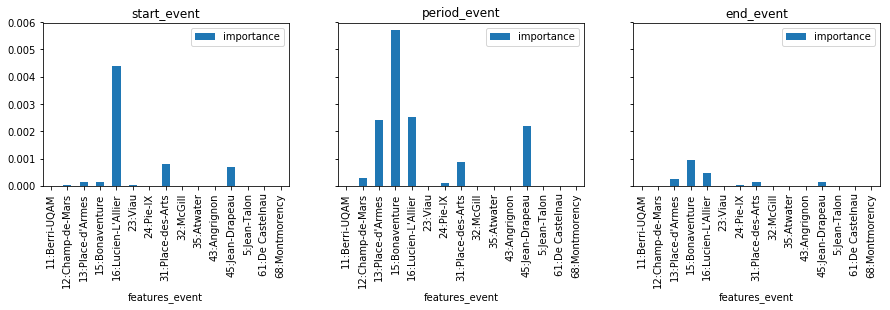

MODEL Stop id:15, stop name:Station Bonaventure


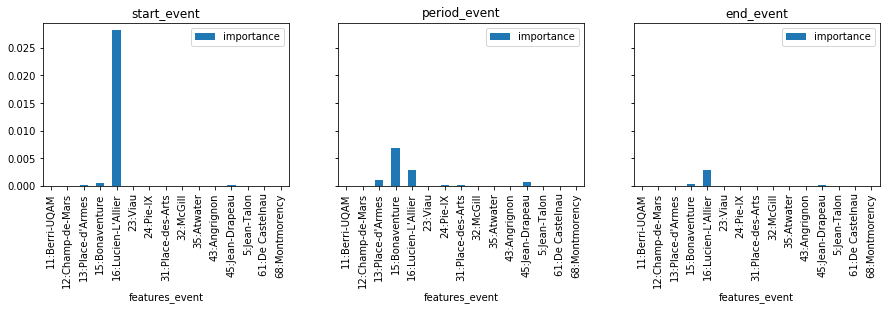

MODEL Stop id:44, stop name:Station Longueuil-Université-de-Sherbrooke


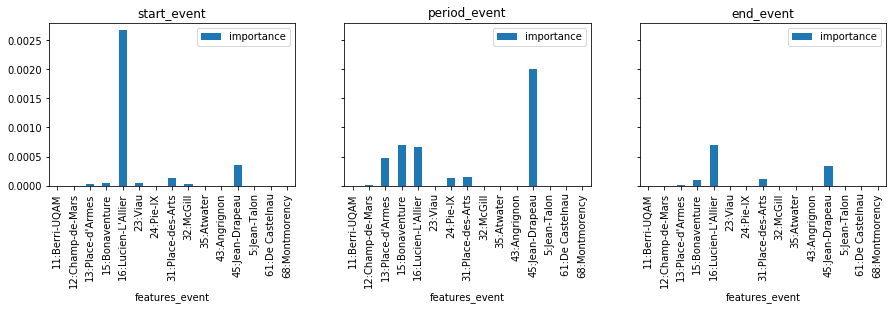

MODEL Stop id:65, stop name:Station Côte-Vertu


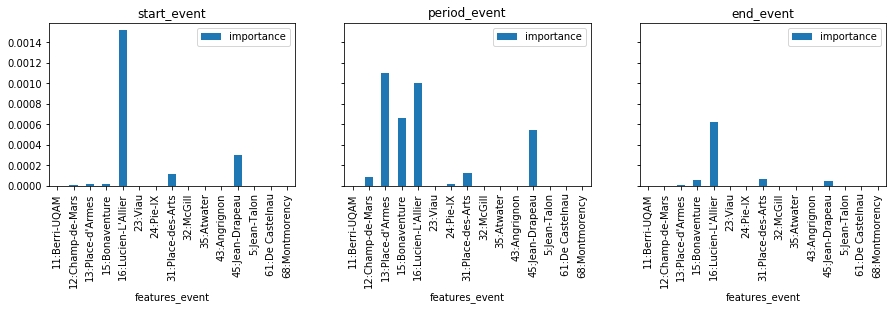

MODEL Stop id:31, stop name:Station Place-des-Arts


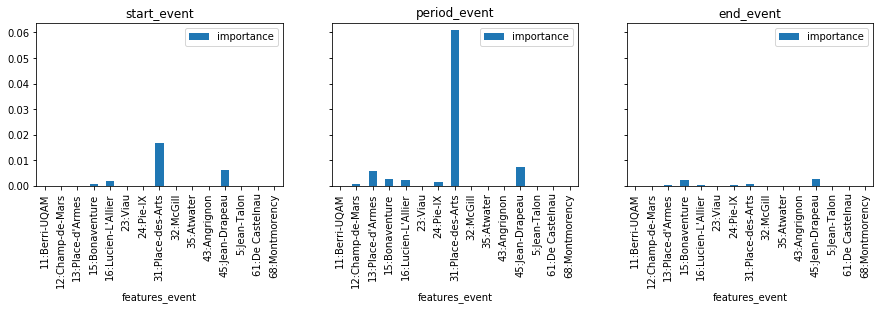

MODEL Stop id:33, stop name:Station Peel


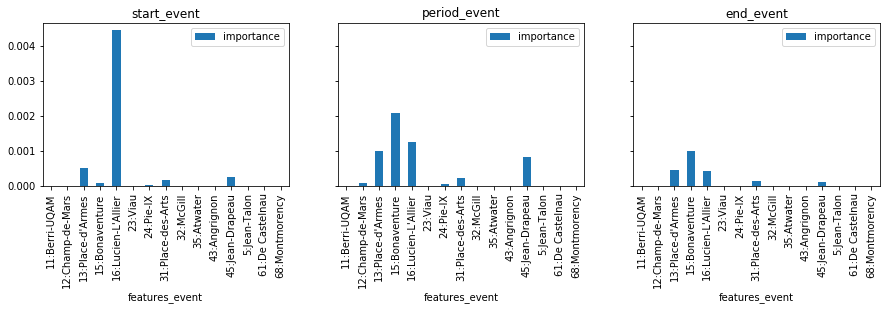

MODEL Stop id:35, stop name:Station Atwater


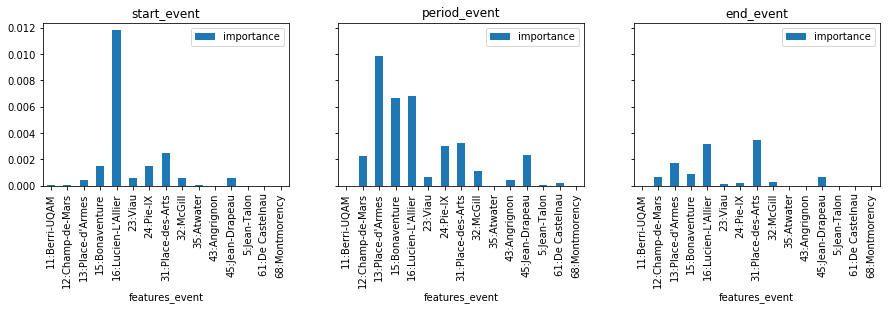

MODEL Stop id:47, stop name:Station Vendôme


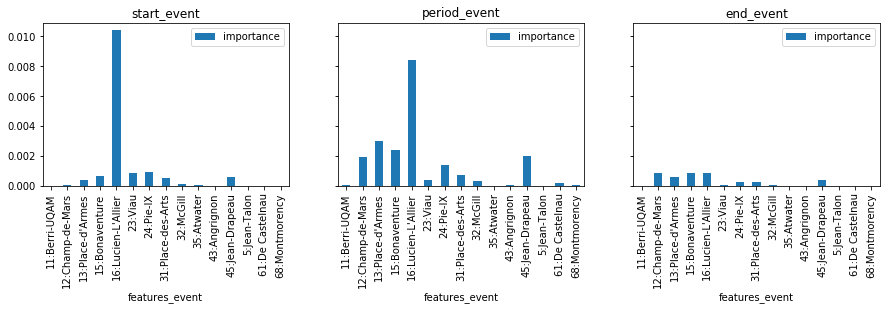

MODEL Stop id:13, stop name:Station Place-d'Armes


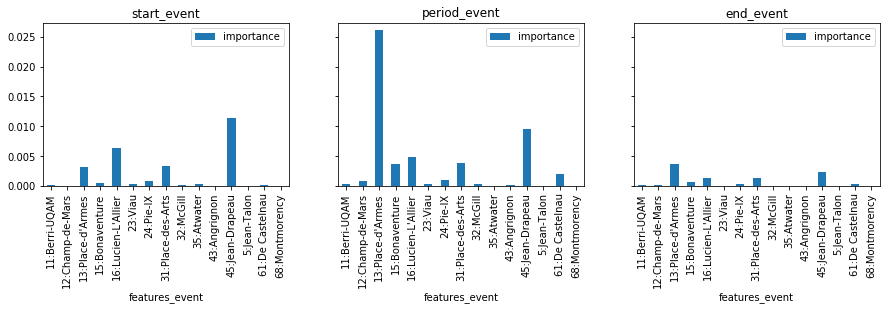

MODEL Stop id:14, stop name:Station Square-Victoria-OACI


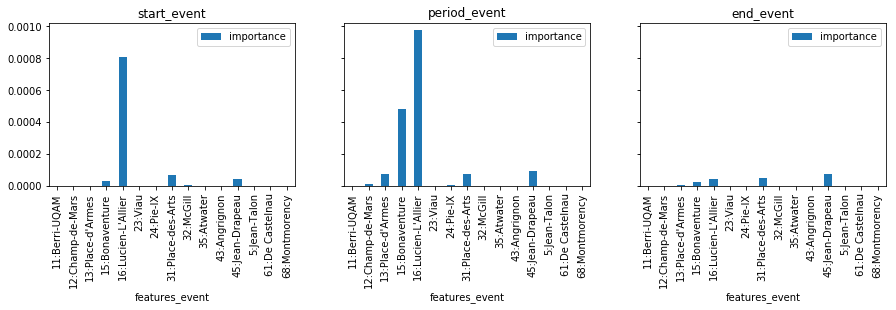

MODEL Stop id:1, stop name:Station Henri-Bourassa


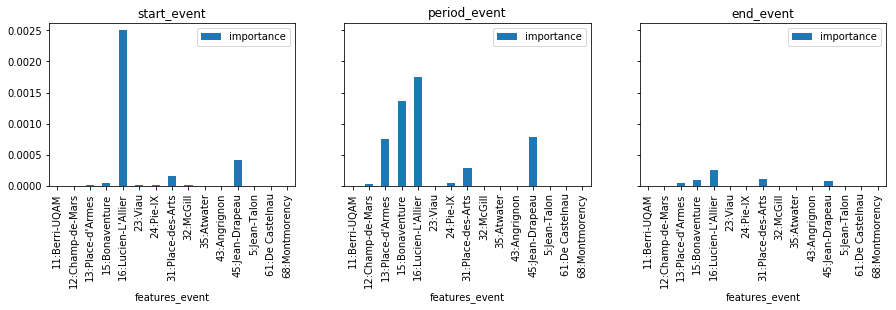

MODEL Stop id:9, stop name:Station Mont-Royal


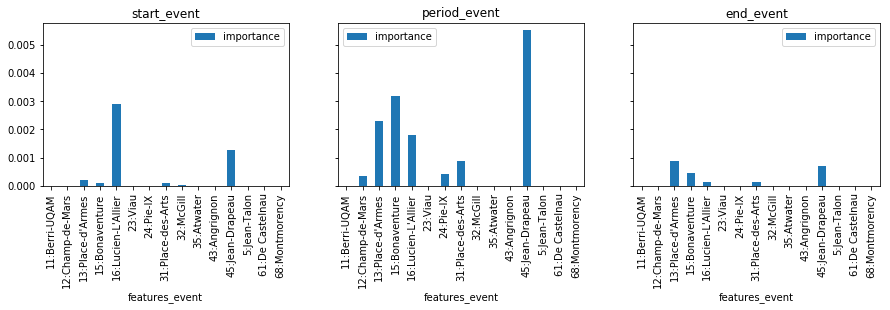

MODEL Stop id:5, stop name:Station Jean-Talon


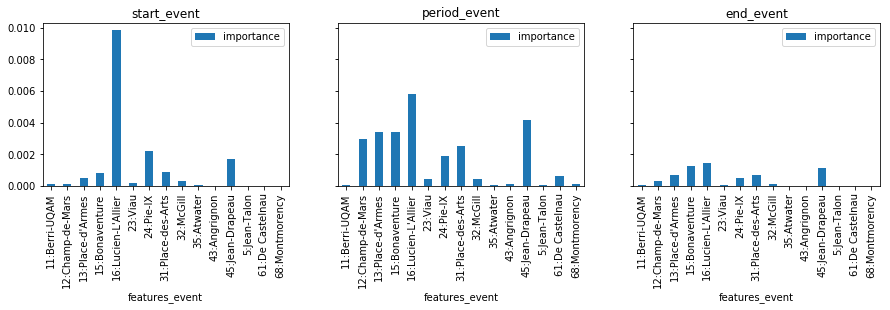

MODEL Stop id:18, stop name:Station Honoré-Beaugrand


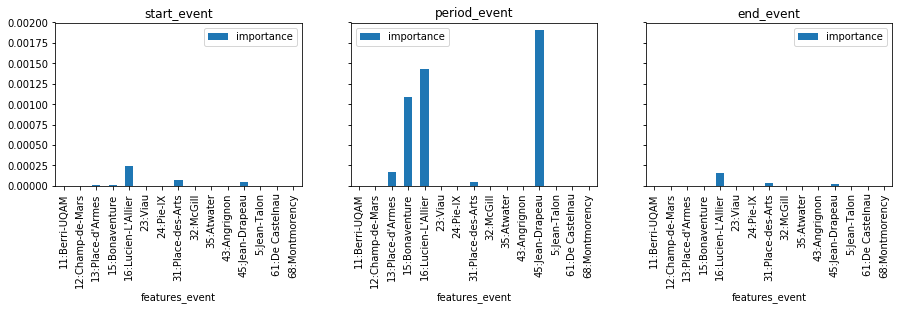

MODEL Stop id:36, stop name:Station Lionel-Groulx


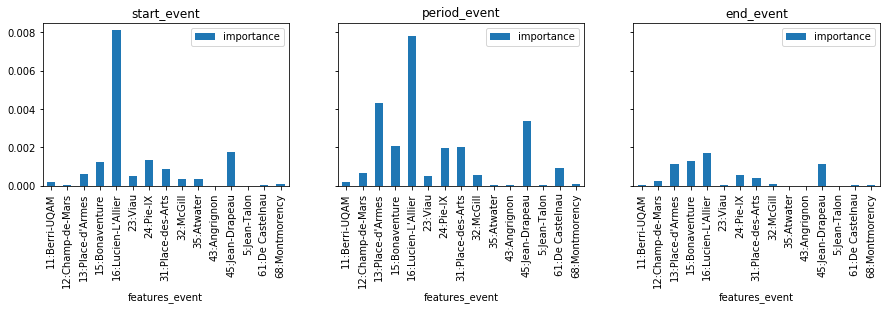

MODEL Stop id:24, stop name:Station Pie-IX


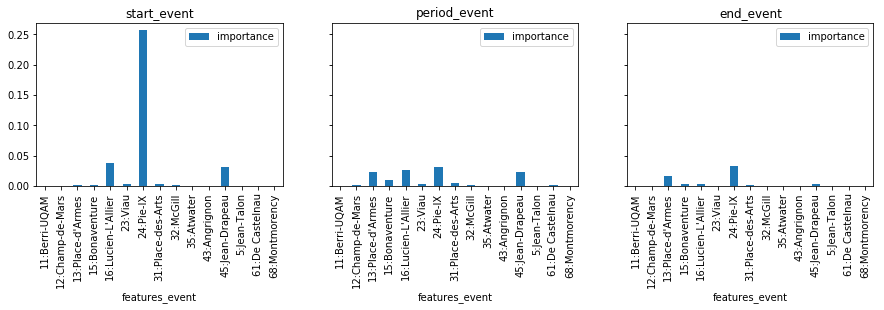

MODEL Stop id:68, stop name:Station Montmorency


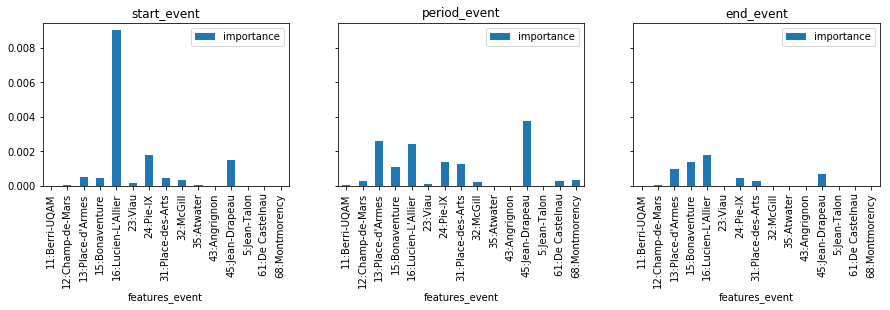

MODEL Stop id:43, stop name:Station Angrignon


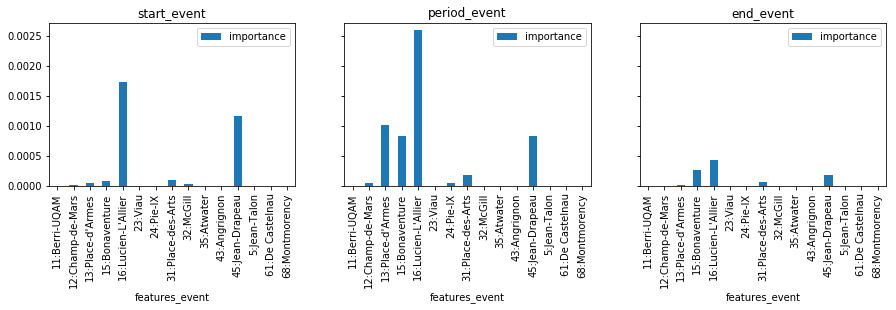

MODEL Stop id:8, stop name:Station Laurier


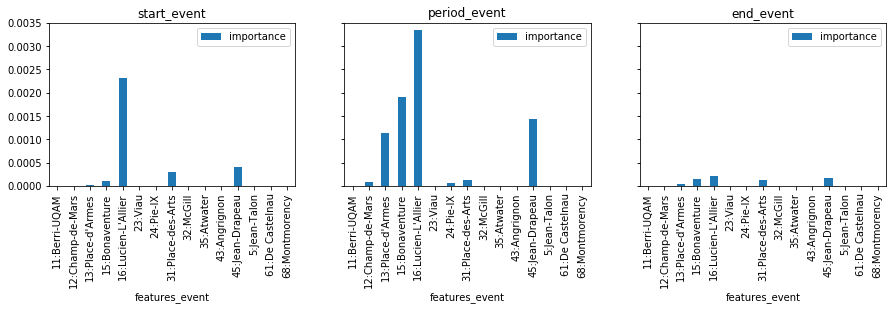

MODEL Stop id:64, stop name:Station Saint-Michel


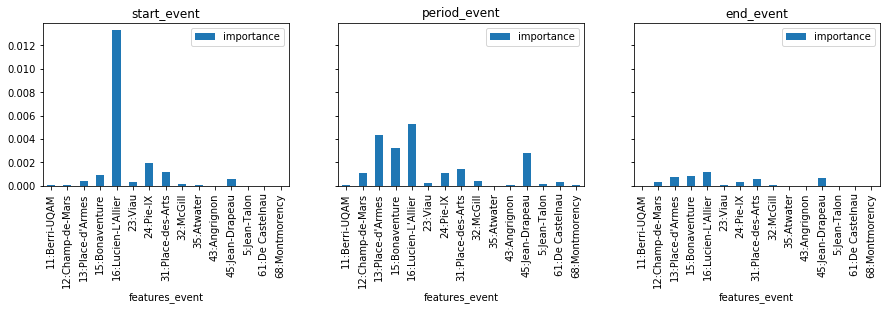

MODEL Stop id:10, stop name:Station Sherbrooke


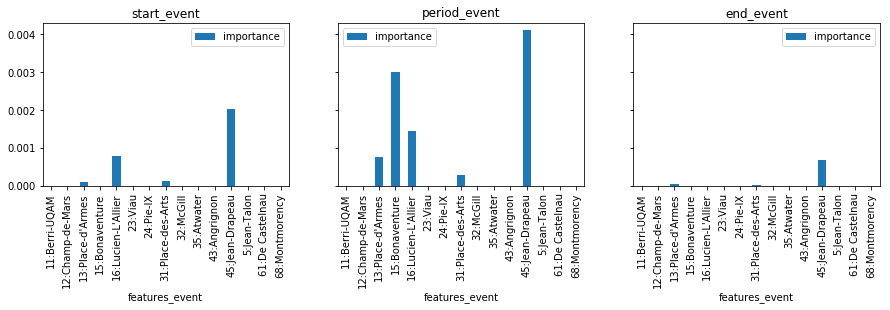

MODEL Stop id:55, stop name:Station Côte-des-Neiges


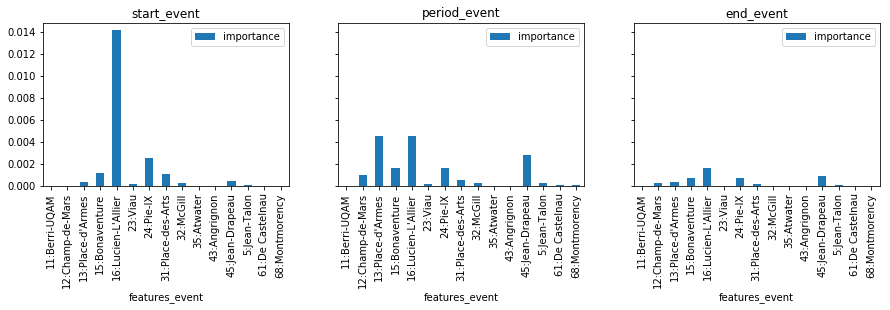

MODEL Stop id:3, stop name:Station Crémazie


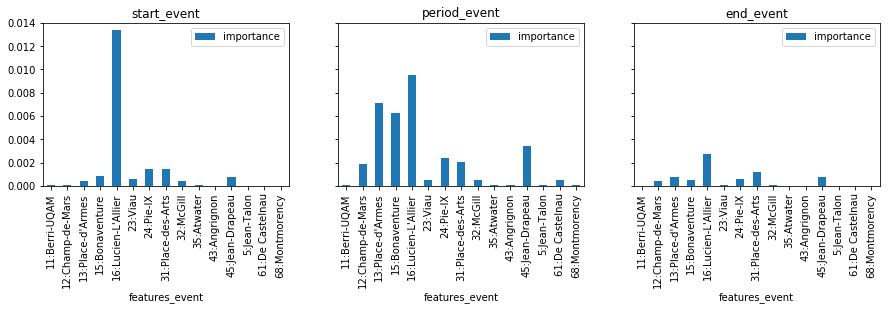

MODEL Stop id:49, stop name:Station Snowdon


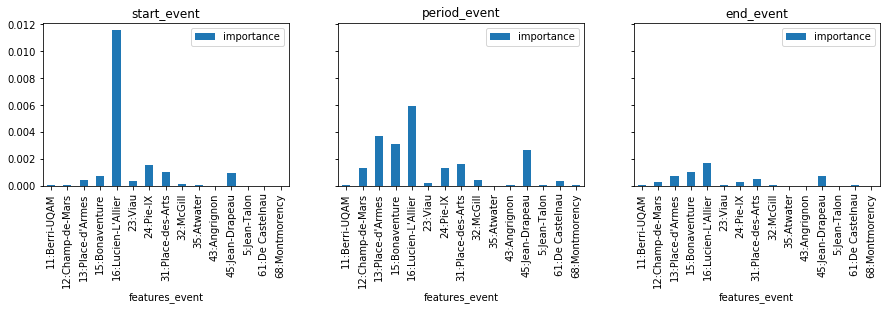

MODEL Stop id:51, stop name:Station Plamondon


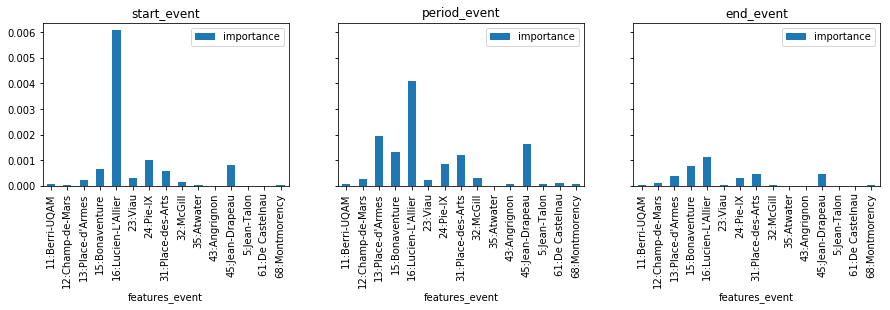

MODEL Stop id:2, stop name:Station Sauvé


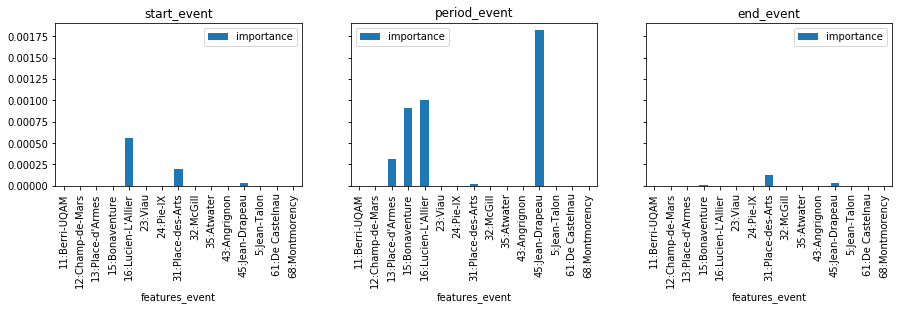

MODEL Stop id:19, stop name:Station Radisson


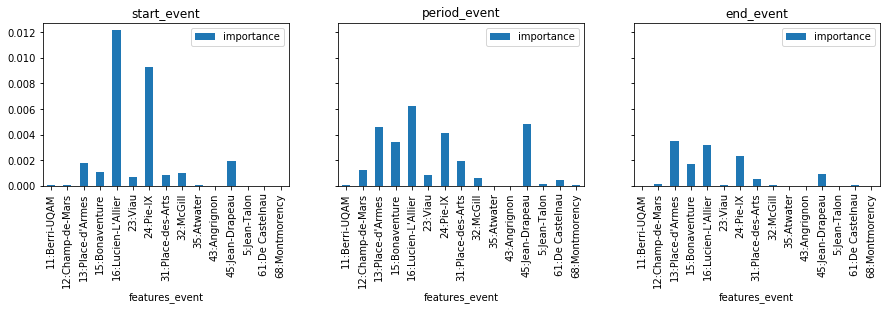

MODEL Stop id:56, stop name:Station Université-de-Montréal


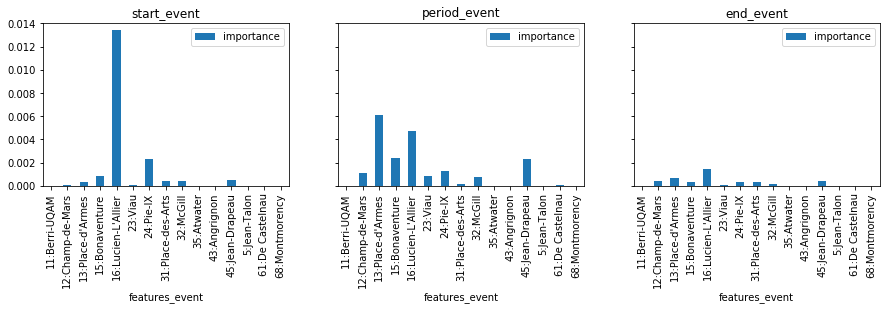

MODEL Stop id:7, stop name:Station Rosemont


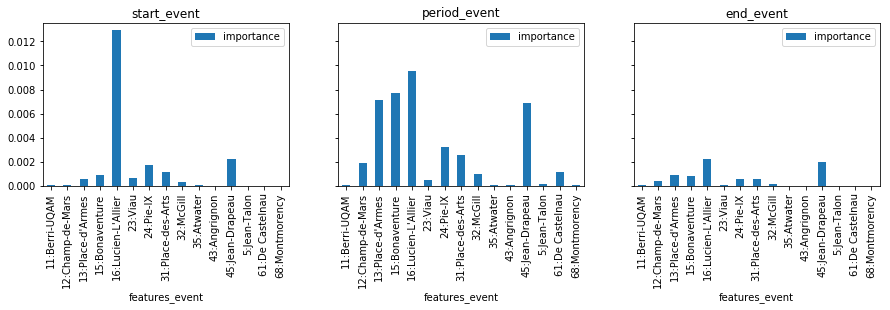

MODEL Stop id:6, stop name:Station Beaubien


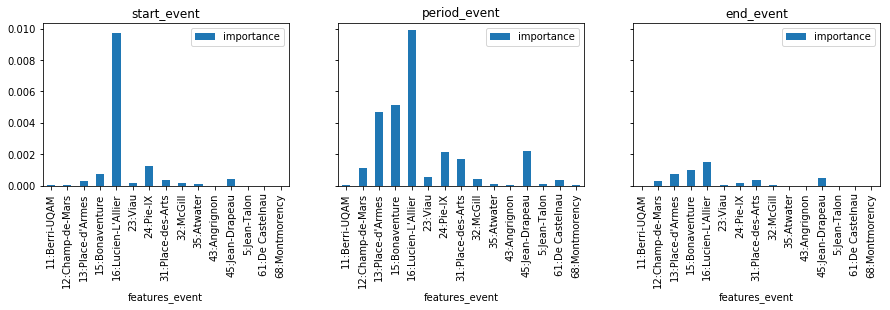

MODEL Stop id:4, stop name:Station Jarry


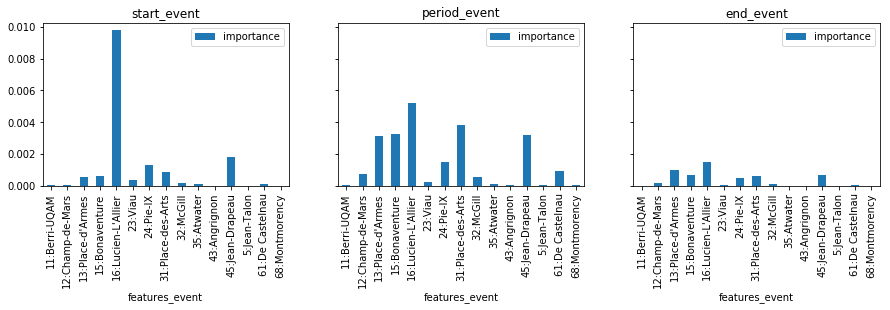

MODEL Stop id:48, stop name:Station Villa-Maria


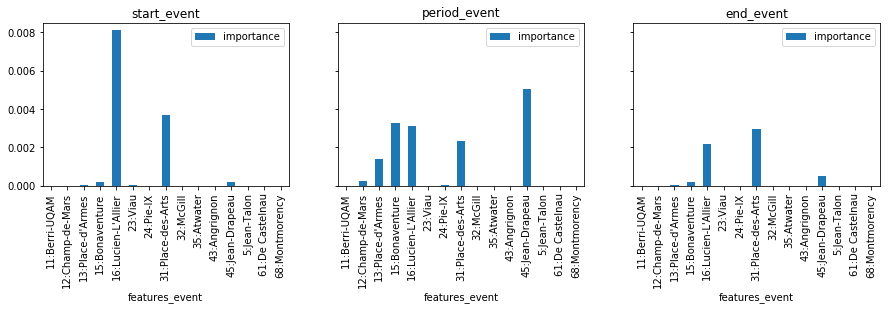

MODEL Stop id:66, stop name:Station Cartier


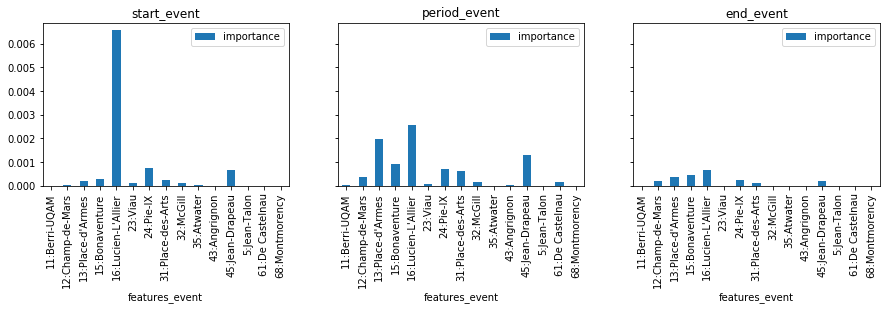

MODEL Stop id:25, stop name:Station Joliette


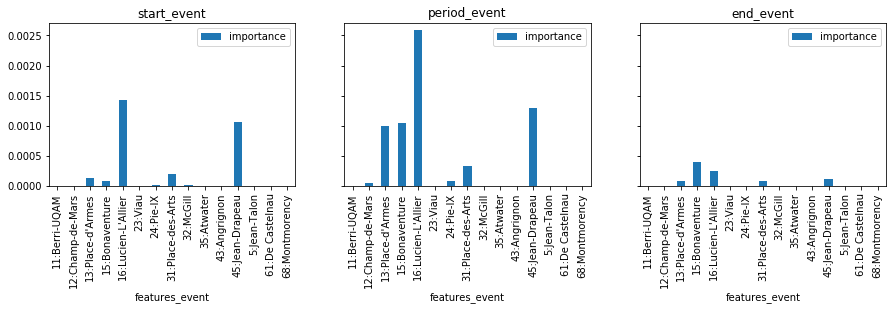

MODEL Stop id:23, stop name:Station Viau


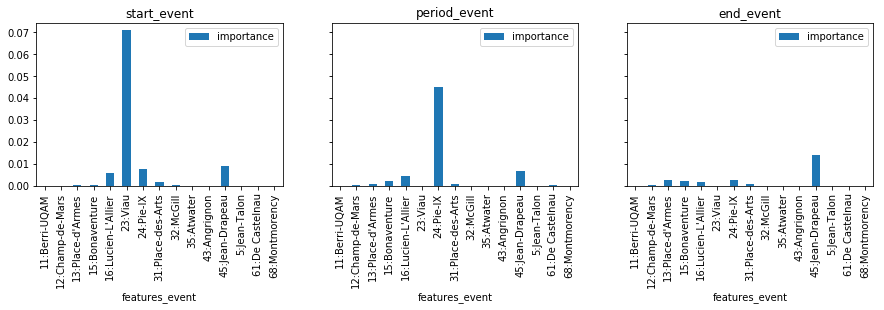

MODEL Stop id:28, stop name:Station Papineau


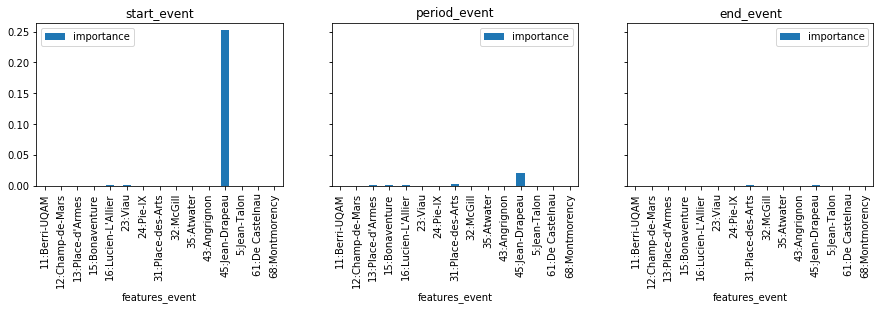

MODEL Stop id:39, stop name:Station De l'Église


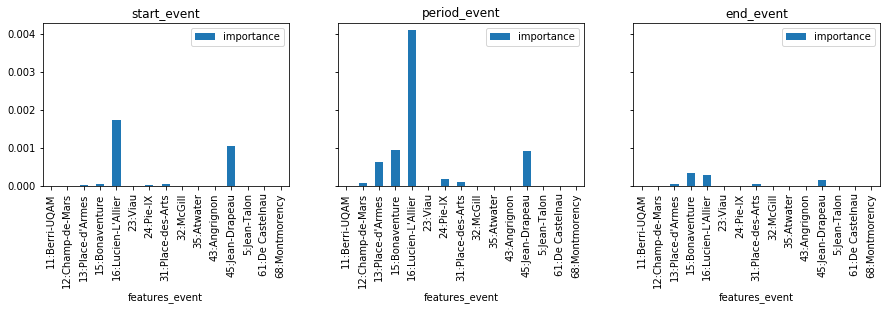

MODEL Stop id:54, stop name:Station Du Collège


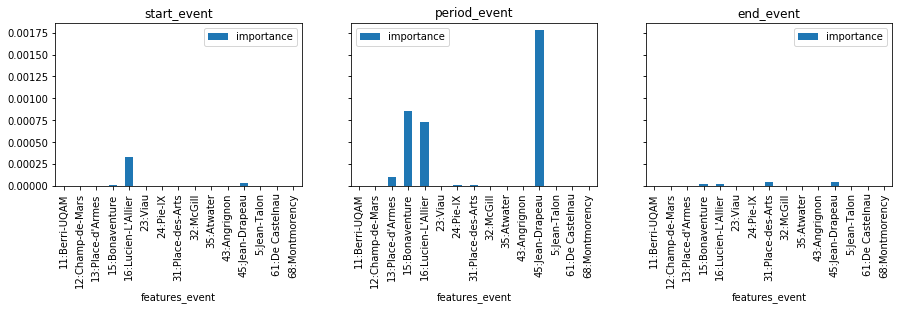

MODEL Stop id:60, stop name:Station Parc


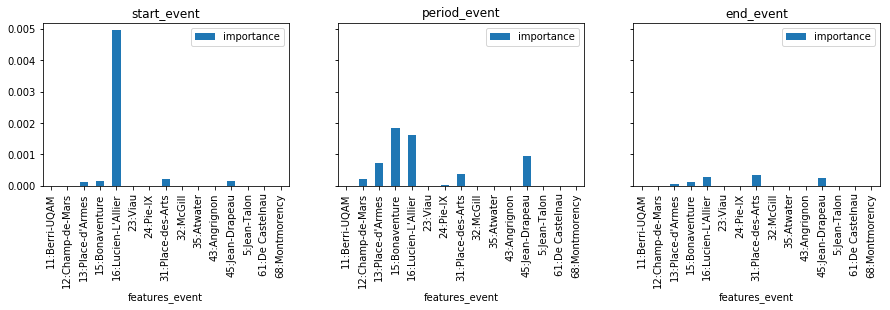

MODEL Stop id:27, stop name:Station Frontenac


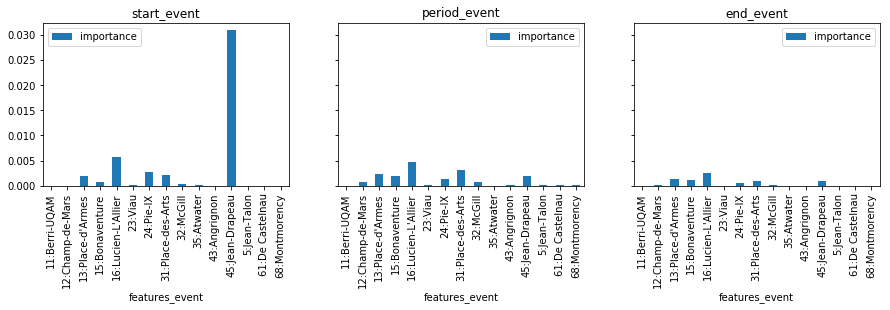

MODEL Stop id:20, stop name:Station Langelier


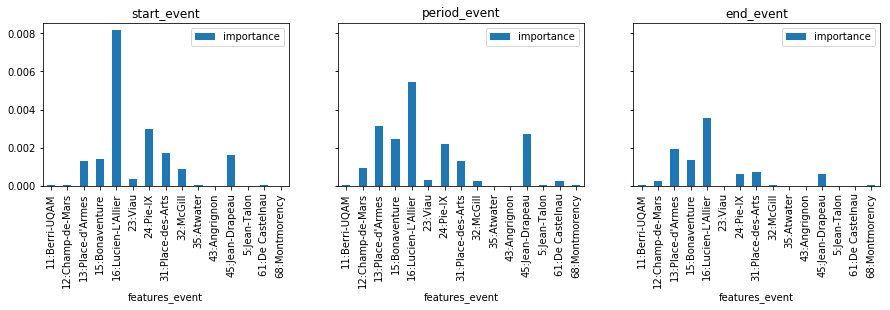

MODEL Stop id:46, stop name:Station Place-Saint-Henri


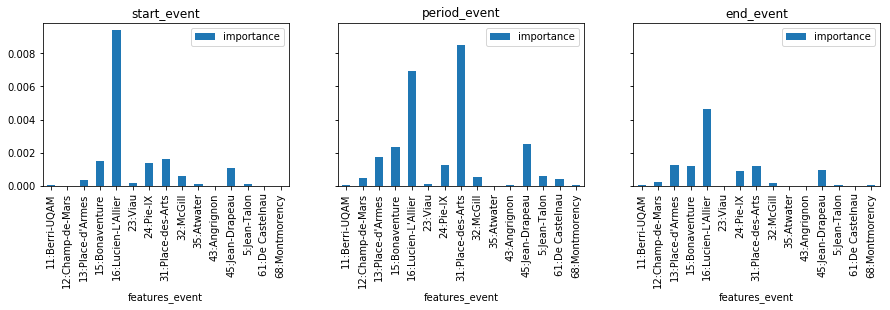

MODEL Stop id:12, stop name:Station Champ-de-Mars


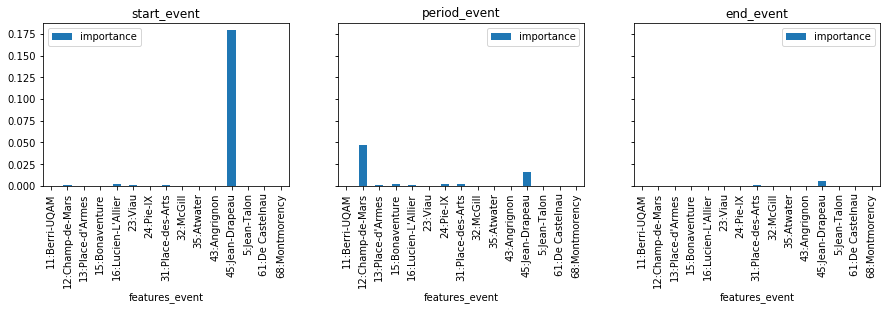

MODEL Stop id:21, stop name:Station Cadillac


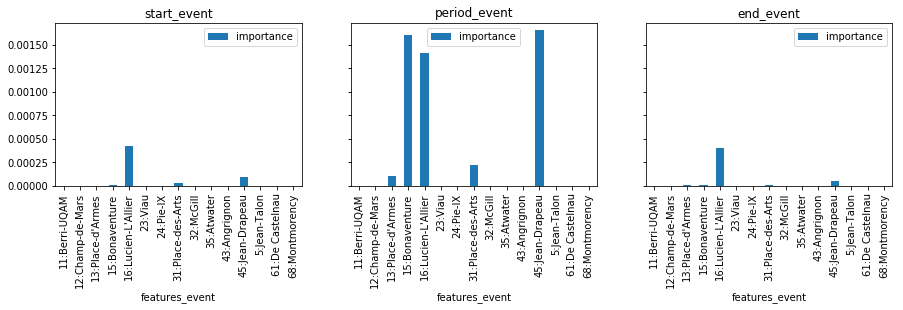

MODEL Stop id:62, stop name:Station Fabre


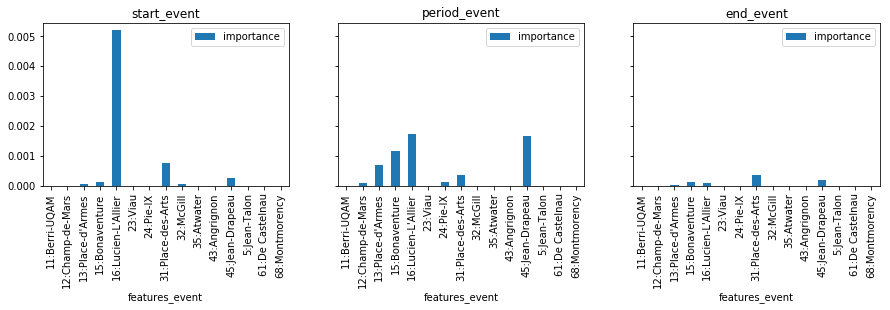

MODEL Stop id:52, stop name:Station Namur


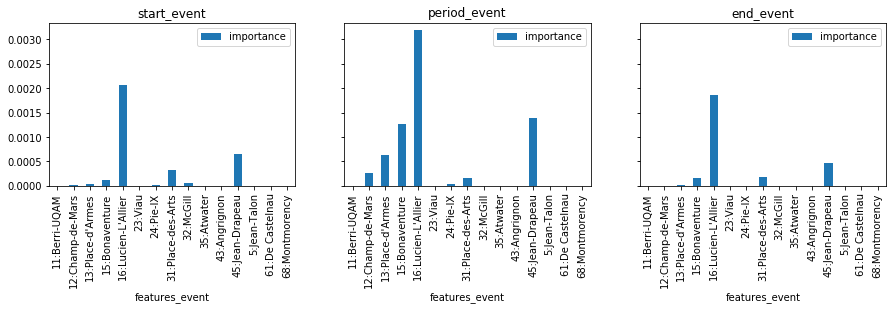

MODEL Stop id:41, stop name:Station Jolicoeur


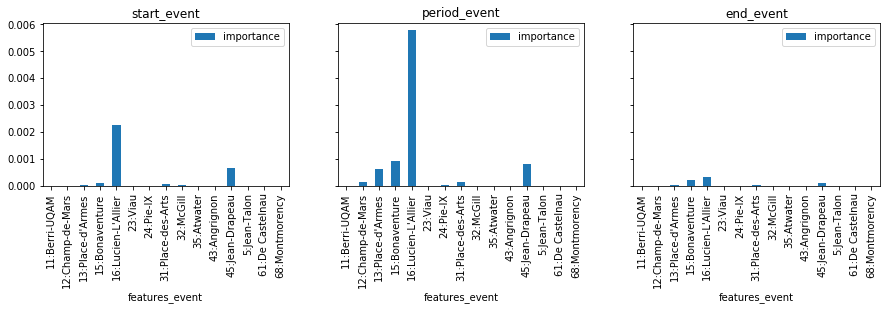

MODEL Stop id:50, stop name:Station Côte-Sainte-Catherine


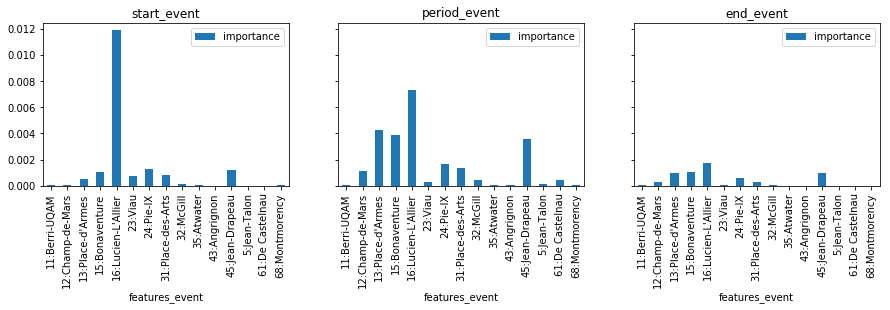

MODEL Stop id:30, stop name:Station Saint-Laurent


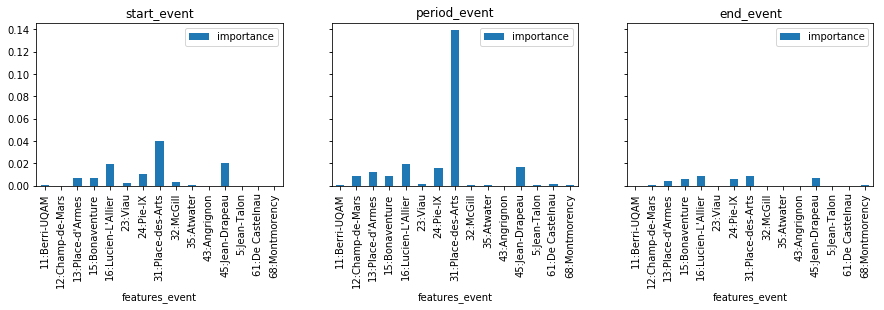

MODEL Stop id:16, stop name:Station Lucien-L'Allier


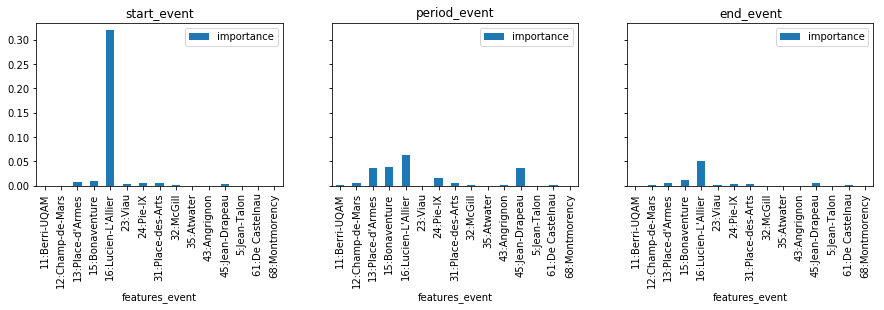

MODEL Stop id:37, stop name:Station Charlevoix


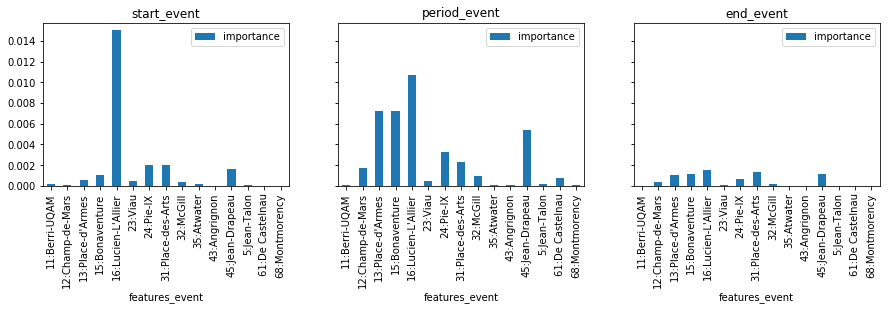

MODEL Stop id:40, stop name:Station Verdun


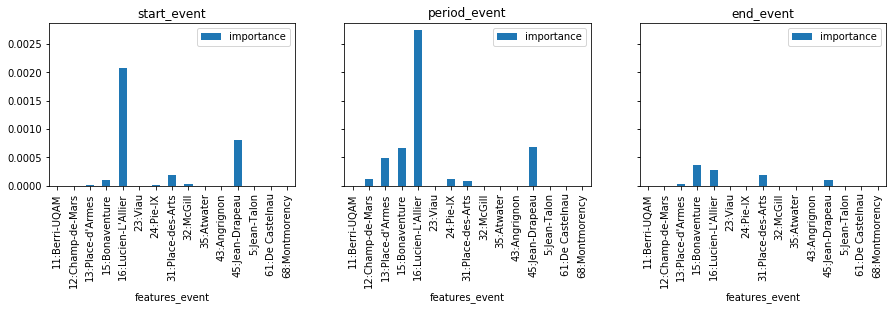

MODEL Stop id:26, stop name:Station Préfontaine


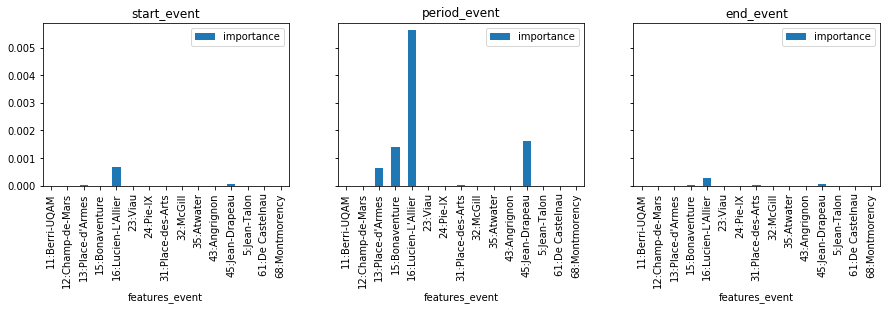

MODEL Stop id:67, stop name:Station De la Concorde


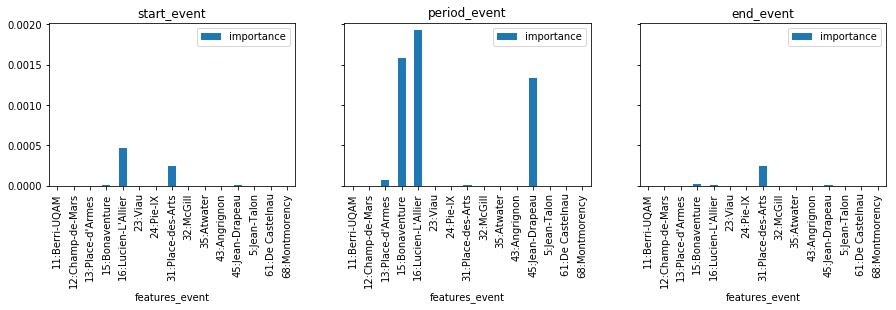

MODEL Stop id:57, stop name:Station Édouard-Montpetit


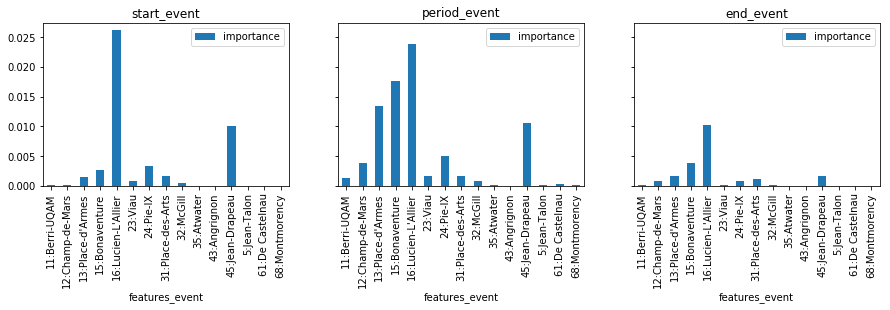

MODEL Stop id:61, stop name:Station De Castelnau


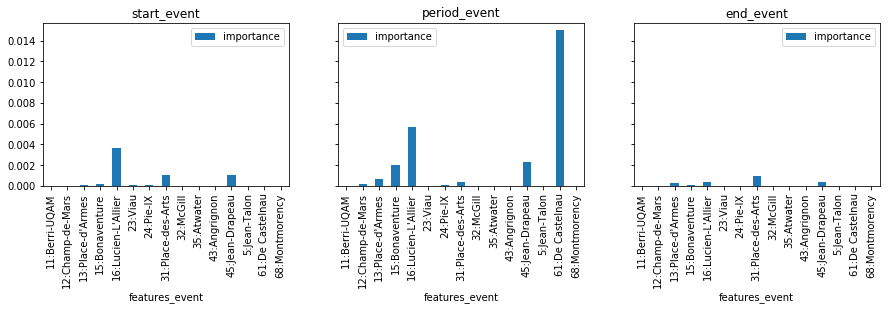

MODEL Stop id:42, stop name:Station Monk


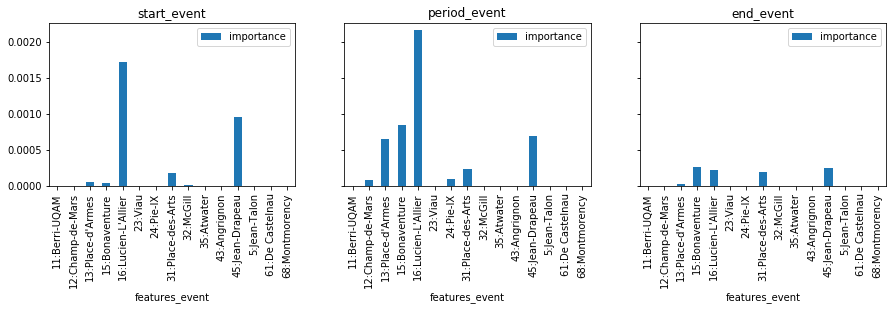

MODEL Stop id:45, stop name:Station Jean-Drapeau


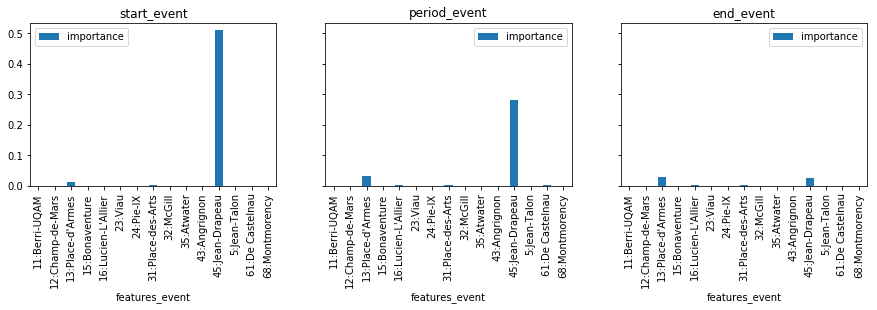

MODEL Stop id:38, stop name:Station LaSalle


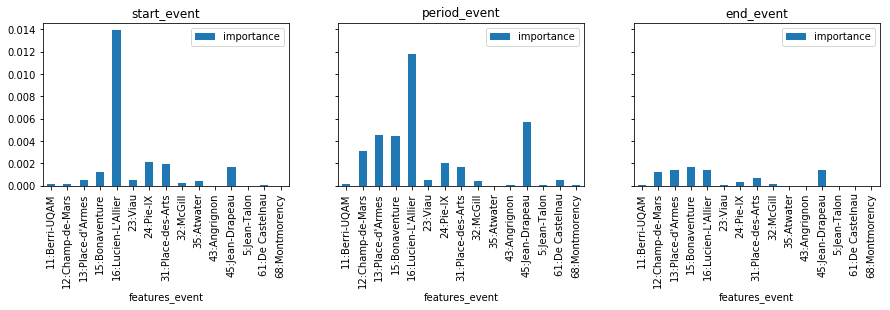

MODEL Stop id:29, stop name:Station Beaudry


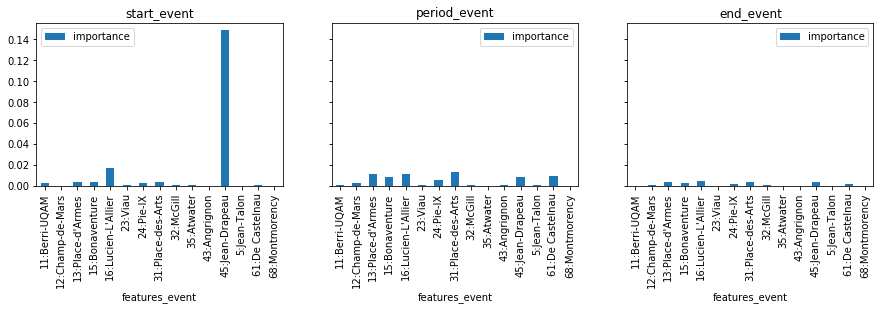

MODEL Stop id:58, stop name:Station Outremont


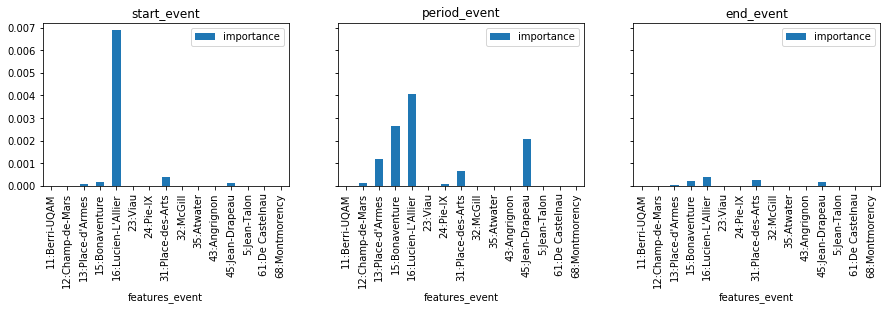

MODEL Stop id:63, stop name:Station D'Iberville


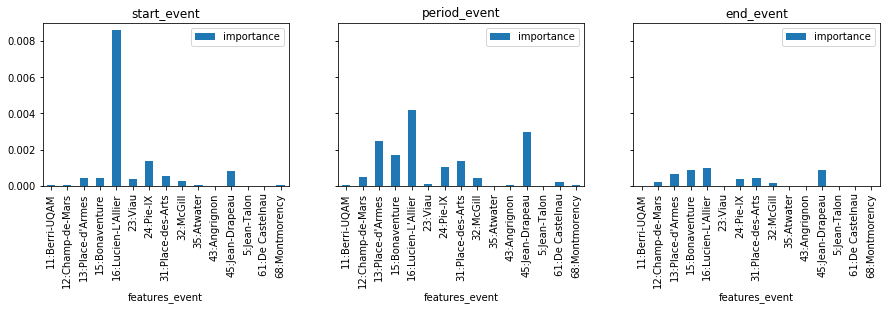

MODEL Stop id:22, stop name:Station Assomption


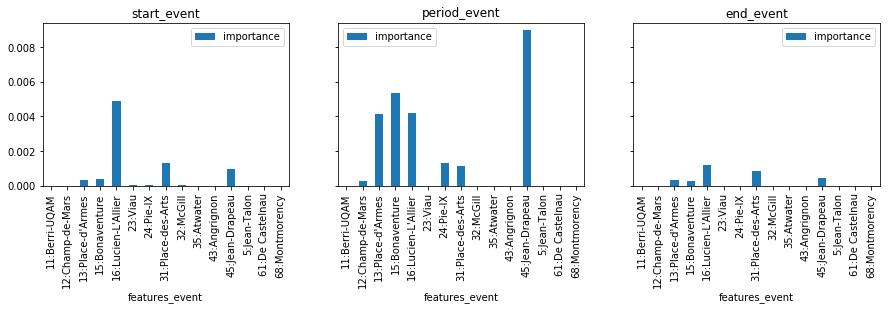

MODEL Stop id:59, stop name:Station Acadie


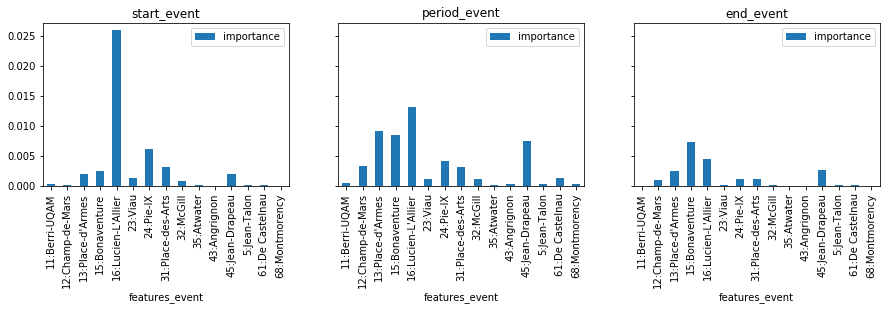

MODEL Stop id:53, stop name:Station De la Savane


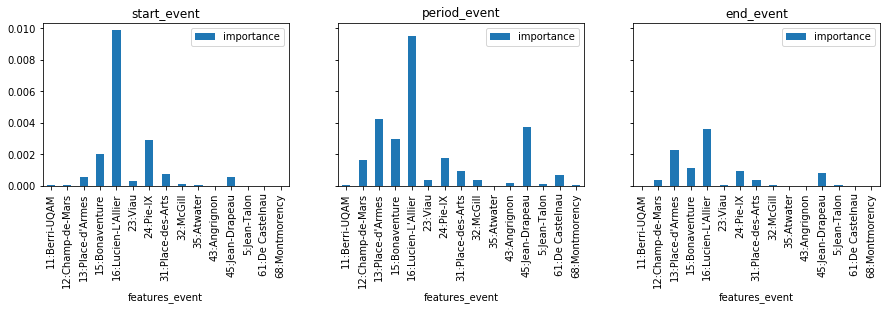

MODEL Stop id:17, stop name:Station Georges-Vanier


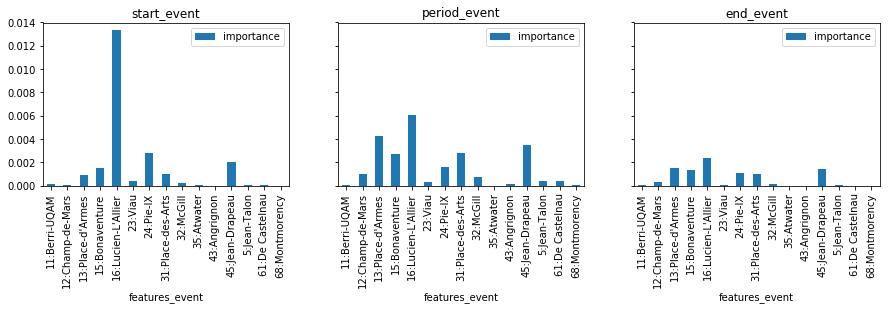

In [91]:
df_station = pd.read_csv('/home/toque/data2/montreal/stm/data/station_info.csv')
dict_id_name = dict(df_station[['stop_id','stop_name']].values)


for ix,ts in enumerate(time_series):
    my_model = rf_list[ix]
    
    print('MODEL Stop id:{}, stop name:{}'.format(ts, dict_id_name[int(ts)]))
    df = pd.DataFrame(data=Xnames[:-9], columns = ['features'])
    df['importance'] = my_model.feature_importances_[:-9]
    df['features_event'] = [i.split('-')[0] + ':' + dict_id_name[int(i.split('-')[0])][8:] for i in Xnames[:-9]]
    df['time'] = [i.split('-')[1] for i in [i.split('-T')[0] for i in Xnames[:-9]]]
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (15,3))
    df = df.groupby(['time', 'features_event']).sum().reset_index().set_index('time')
    
    df.loc['start_event'].plot.bar(x='features_event', y= 'importance', ax = ax1)
    ax1.set_title('start_event')
    df.loc['period_event'].plot.bar(x='features_event', y= 'importance', ax = ax2)
    ax2.set_title('period_event')
    df.loc['end_event'].plot.bar(x='features_event', y= 'importance', ax = ax3)
    ax3.set_title('end_event')
    plt.xticks(rotation=90)
    plt.show()

In [164]:
df_station = pd.read_csv('/home/toque/data2/montreal/stm/data/station_info.csv')
dict_id_name = dict(df_station[['stop_id','stop_name']].values)

list_df_ts = []
for ix,ts in enumerate(time_series):
    my_model = rf_list[ix]
    df = pd.DataFrame(data=[dict_id_name[int(i.split('-')[0])][8:] for i in Xnames[:-9]], columns = ['features_event'])
    df[dict_id_name[int(ts)][8:]] = my_model.feature_importances_[:-9]
    df = df.groupby('features_event').sum()
    list_df_ts.append(df)
df = list_df_ts[0].join(list_df_ts[1:])
    
    

## Features importance per model (importance without normalization per model)

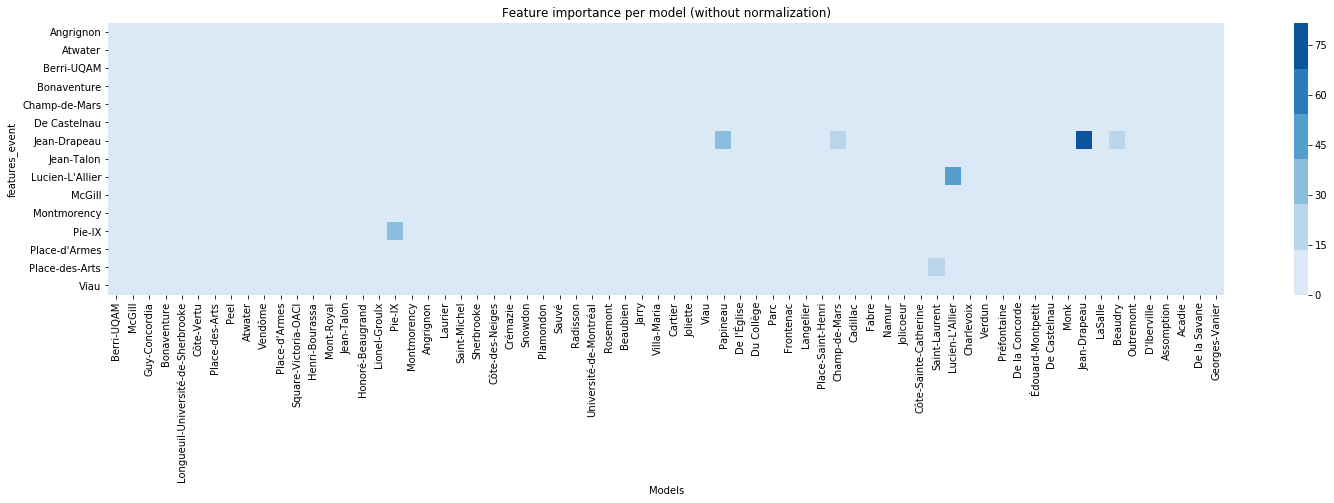

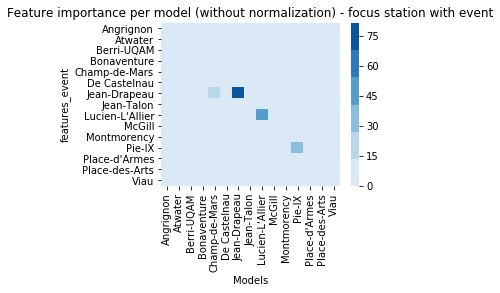

In [168]:
import seaborn as sns

cmap = sns.color_palette("Blues")
fig, ax = plt.subplots(figsize=(25,5))
sns.heatmap((df*100), ax=ax, cmap=cmap )
plt.title('Feature importance per model (without normalization)')
plt.xlabel('Models')
plt.show()


cmap = sns.color_palette("Blues")
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap((df*100)[df.index.values], ax=ax, cmap=cmap )
plt.title('Feature importance per model (without normalization) - focus station with event')
plt.xlabel('Models')
plt.show()

## Features importance per model (importance normalized per model)

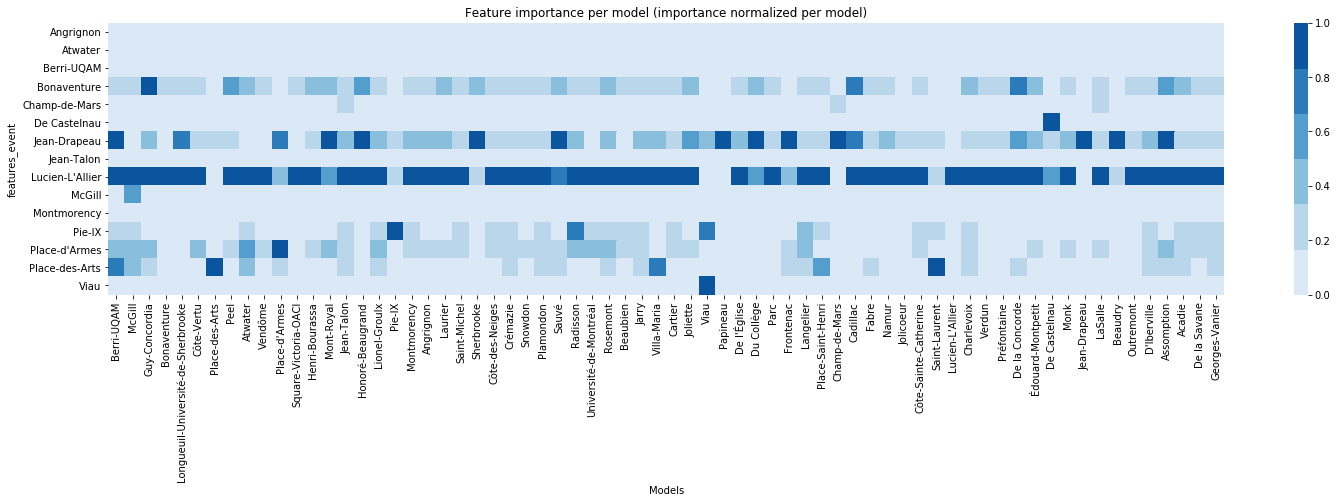

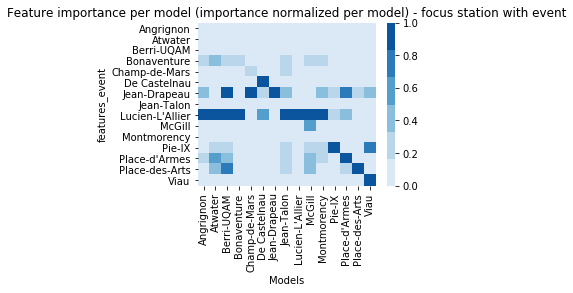

In [151]:
import seaborn as sns
cmap = sns.color_palette("Blues")
fig, ax = plt.subplots(figsize=(25,5))
sns.heatmap((df/df.max(axis=0).values), ax=ax, cmap=cmap )
plt.title('Feature importance per model (importance normalized per model)')
plt.xlabel('Models')
plt.show()

import seaborn as sns
cmap = sns.color_palette("Blues")
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap((df/df.max(axis=0).values)[df.index.values], ax=ax, cmap=cmap )
plt.title('Feature importance per model (importance normalized per model) - focus station with event')
plt.xlabel('Models')
plt.show()

## Events features importance per model

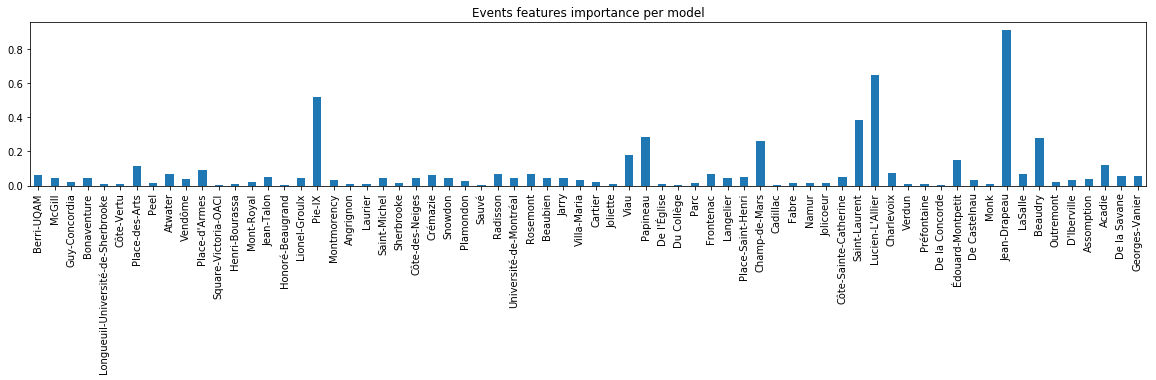

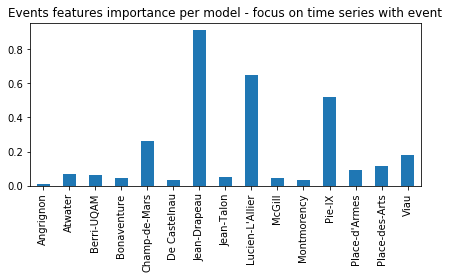

In [161]:
df.sum(axis=0).plot.bar(figsize=(20,3))
plt.title('Events features importance per model')
plt.show()

df[df.index.values].sum(axis=0).plot.bar(figsize=(7,3))
plt.title('Events features importance per model - focus on time series with event')
plt.show()